In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import pandas as pd

In [2]:
import glob

files = sorted(glob.glob('data/RV/lsd profiles/*'))
f_names = [f.split('/')[-1].split('_lin')[0] for f in files]
lsd = pd.DataFrame({"ID": f_names, "lsd": files})

spectra_dir = 'data/Spectra/SONG/'
all_spectra_files = np.array(sorted(glob.glob(spectra_dir + '*.fits')))
epochs = np.arange(len(all_spectra_files))
m = ~((epochs == 60) | (epochs == 15))
all_spectra_files = all_spectra_files[m]
all_spectra_id = [f.split('/')[-1].split('.')[0] for f in all_spectra_files]
spectra = pd.DataFrame({'ID': all_spectra_id, 'spectra': all_spectra_files})

df = pd.merge(lsd, spectra, on='ID')

In [3]:
df['BJD_MID'] = [pf.getheader( row.spectra )['BJD-MID'] for i, row in df.iterrows()]
df['BVC'] = [pf.getheader( row.spectra )['BVC'] for i, row in df.iterrows()]

In [4]:
from scipy.optimize import minimize

def model(theta, x):
    a, d, x0 = theta
    gaussian = a*np.exp(-(x-x0)**2/(2*d**2)) - 1#c
    return -1*gaussian

def func(theta, x, y):
    gaussian = model(theta, x)
    return 0.5*np.sum((y-gaussian)**2)#/sigma2 + np.log(sigma2))

def fit_gaussian(x, y, x0):
    res = minimize(func, x0, args=(x, y))
    return res

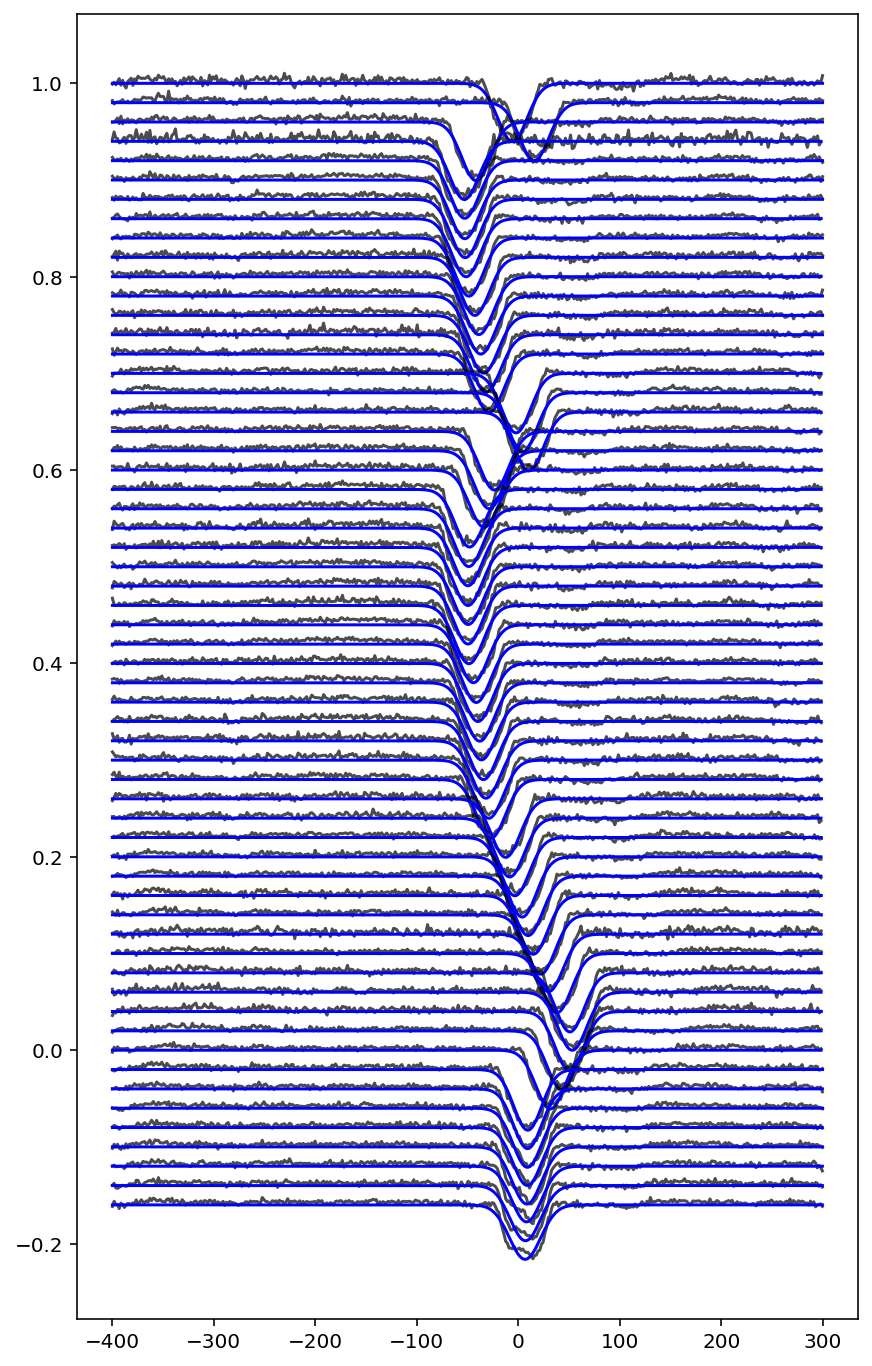

In [7]:
plt.figure(figsize=[7, 12])

RV = []
for index, row in df.iterrows():
    wav, lsd = np.loadtxt(row.lsd).T
    
    x0 = [0.05, 20, wav[np.argmin(lsd)]]
    p = fit_gaussian(wav, lsd, x0)
    RV.append(p.x[-1])
    plt.plot(wav, lsd - index*0.02, c='black', alpha=0.7)
    plt.plot(wav, model(p.x, wav) - index*0.02, c='blue')
    
df['RV'] = RV

In [16]:
df['RV'] += df['BVC']

In [22]:
porb = 51.4213

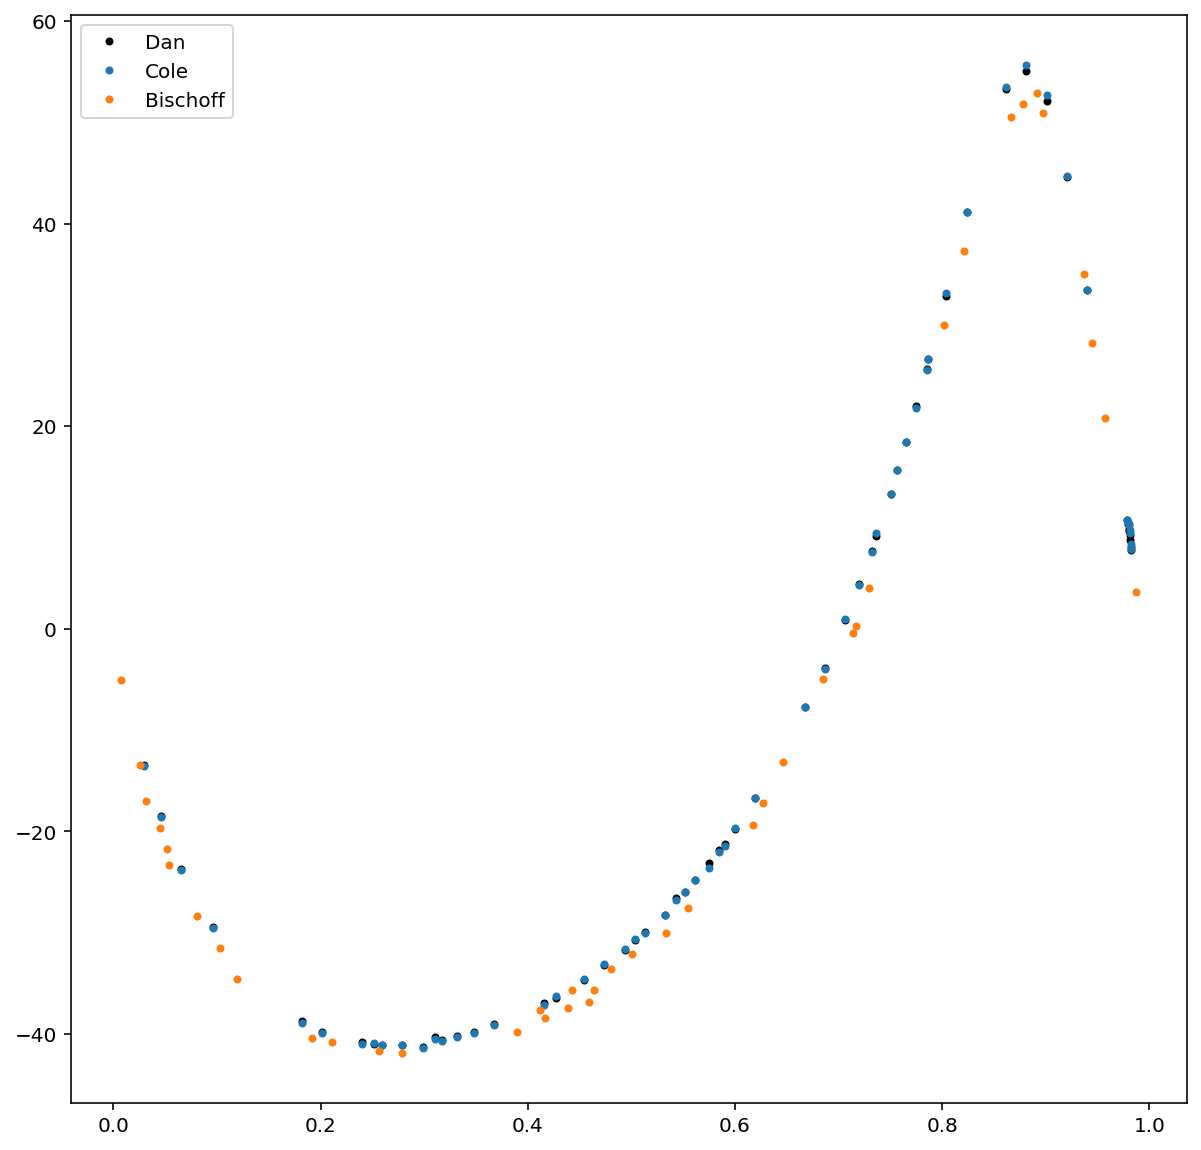

In [43]:
ref_rv = 2400000
btjd = 2457000


plt.figure(figsize=[10,10])
rv_song = np.loadtxt('data/RV/SONG.txt')
# rv_song2 = np.loadtxt('data/RV/SONG2.txt')
rv_bischoff = np.loadtxt('data/RV/bischoff_rv_fixed_time.txt')
# time, flux, flux_err = np.loadtxt('data/photometry/tess_corrected.txt', usecols=(0,1,2)).T

# Correct all to the same reference time
# time += btjd
# rv_song[:,0] += ref_rv - btjd
# rv_bischoff[:,0] += ref_rv

plt.plot((rv_song[:,0] + ref_rv - btjd) % porb / porb, rv_song[:,1], '.k', label='Dan')
plt.plot((df['BJD_MID'] + ref_rv - btjd) % porb / porb, df['RV'], '.', label='Cole')
plt.plot(rv_bischoff[:,0] % porb / porb, rv_bischoff[:,1], '.', label='Bischoff')

plt.legend()
# plt.xlim(0.97, 0.985)
# plt.ylim(5.,12.5)

In [30]:
rv_bischoff[:,0]

array([431.3962 , 456.51247, 457.50988, 464.42365, 465.47306, 485.36787,
       486.37752, 491.33144, 499.63239, 500.3091 , 507.34876, 511.35961,
       518.35851, 519.50551, 520.36909, 527.39125, 528.54961, 535.37655,
       546.48331, 547.46095, 549.42603, 555.42805, 562.41092, 563.41089,
       568.39729, 575.5008 , 576.49245, 588.37844, 589.49422, 590.32846,
       591.38119, 597.38293, 602.3423 , 611.49387, 616.39098, 617.45327,
       618.38174, 619.37289, 638.50127, 644.47055, 659.27274])